In [62]:
import xarray as xr
import fsspec
import os
from vcm.select import RegionOfInterest
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

kg_m2s_to_mm_day = (1e3 * 86400) / 997.0
kg_m2_to_mm  = 1000. / 997.0

import xarray as xr
import numpy as np
import fsspec
import intake
from vcm.catalog import catalog 
import fv3viz
import cftime
import datetime
import pandas as pd
#import proplot

import matplotlib.pyplot as plt
import os
from datetime import timedelta
#import seaborn as sns
import vcm

plt.rcParams.update({'font.sans-serif':'TeX Gyre Heros'})


slmsk = catalog["landseamask/c48"].read()
grid = catalog["grid/c48"].read()

figsize=(12,4)
col_wrap = 2
rename_dims = {"grid_xt": "x", "grid_yt": "y", "grid_y": "y_interface", "grid_x": "x_interface"}

tick_loc = np.array([-60, -30, -15, 0, 15, 30, 60])
tick_loc_sin = np.sin(tick_loc * np.pi/180)

def save_fig(name: str, dpi: int=150,):
    plt.savefig(f"figures/pdf/{name}.pdf", dpi=dpi, bbox_inches='tight')
    plt.savefig(f"figures/png/{name}.png", dpi=dpi, bbox_inches='tight')
    plt.savefig(f"figures/eps/{name}.eps", format="eps", bbox_inches='tight')

In [55]:
ds_diags = xr.open_dataset("diags_merged.nc")

ds_diags = ds_diags \
    .sel(run=['baseline', 'ML-Tquv', 'ML-Tquv-OCSVM-T', 'ML-Tquv-OCSVM-Tq']) \
    .assign_coords(
        {
            "run": [
                "Baseline",
                "$g_\mathrm{Tquv}$", 
                "$g_\mathrm{Tquv}, \eta_{\mathrm{T, OCSVM}}$",
                "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]
        }
)

lat_vars = [v for v in ds_diags if "latitude" in ds_diags[v].dims]
ds_diags = ds_diags[lat_vars]

pressure_pa = ds_diags.pressure.values
ds_diags = ds_diags.assign_coords({"pressure": pressure_pa/100.})

sin_lat= np.sin( ds_diags.latitude.values * (np.pi/180))
ds_diags_transformed_lat = ds_diags \
    .assign_coords(latitude=sin_lat) \
    .load()

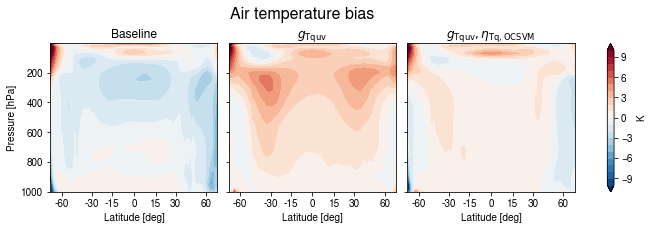

In [56]:
runs=['Baseline', '$g_\mathrm{Tquv}$', "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]
da_ = ds_diags_transformed_lat.sel(run=runs)['air_temperature_pressure_level_zonal_bias']
f = da_ \
    .plot.contourf(
        col='run', 
        x='latitude', 
        yincrease=False,
        levels=21,
        vmax=10,
        figsize=(10,3),
        #cbar_kwargs={"pad": 0.025}
    )
for i, exp in enumerate(da_.run.values):
    ax = f.axes[0][i]
    #plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)

    f.axes[0][i].set_xlabel("Latitude [deg]")    
f.axes[0][0].set_ylabel("Pressure [hPa]")    

f.cbar.ax.set_ylabel("K")

plt.xticks(tick_loc_sin, tick_loc)  # Set label locations.
plt.suptitle("Air temperature bias", x=0.425, y=1.05, fontsize=16)

save_fig("zonal_mean_pressure_air_temperature")

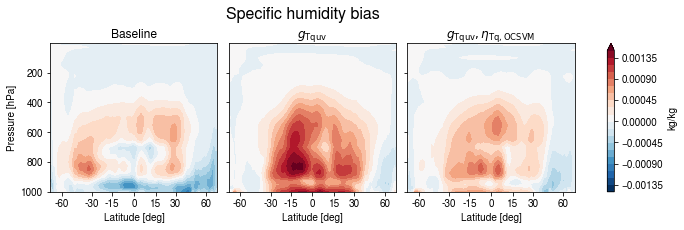

In [57]:
runs=['Baseline', '$g_\mathrm{Tquv}$', "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]

da_ = ds_diags_transformed_lat.sel(run=runs)['specific_humidity_pressure_level_zonal_bias']
f = da_ \
    .plot.contourf(
        col='run', 
        x='latitude', 
        yincrease=False,
        levels=21,
        vmax=0.0015,
        figsize=(10,3),
        cbar_kwargs={"format": mpl.ticker.ScalarFormatter() }
    )
for i, exp in enumerate(da_.run.values):
    ax = f.axes[0][i]
    #plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)

    f.axes[0][i].set_xlabel("Latitude [deg]")    
    
f.axes[0][0].set_ylabel("Pressure [hPa]")    

f.cbar.ax.set_ylabel("kg/kg")
f.cbar.formatter.set_powerlimits((0, 0))    

plt.xticks(tick_loc_sin, tick_loc)  # Set label locations.
plt.suptitle("Specific humidity bias", x=0.425, y=1.05, fontsize=16)
save_fig("zonal_mean_pressure_specific_humidity")

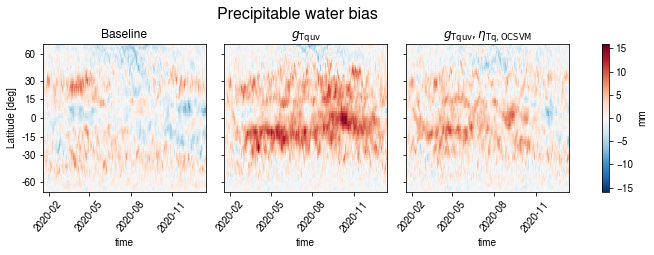

In [58]:
#runs=['baseline', 'ML-Tquv', 'ML-Tquv-OCSVM-Tq']

runs=['Baseline', '$g_\mathrm{Tquv}$', "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]

f = (
        (ds_diags_transformed_lat.sel(run=runs)["pwat_zonal_mean_bias"] )
).plot(col="run", x="time", rasterized=True)

for i, exp in enumerate(ds_diags_transformed_lat.sel(run=runs).run.values):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)

    ax = f.axes[0][0].set_ylabel("Latitude [deg]")    

    

plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.

f.cbar.ax.set_ylabel("mm")
plt.suptitle("Precipitable water bias", x=0.425, y=1.05, fontsize=16)
save_fig("zonal_mean_pwat")

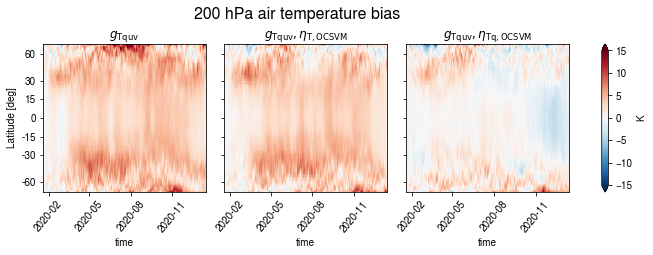

In [66]:
runs=["$g_\mathrm{Tquv}$",  "$g_\mathrm{Tquv}, \eta_{\mathrm{T, OCSVM}}$", "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]
#runs=['Baseline',  "$g_\mathrm{Tquv}, \eta_{\mathrm{T, OCSVM}}$", "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]

da_ = ds_diags_transformed_lat.sel(run=runs)['tmp200_zonal_mean_bias']
f = da_.plot(col="run", x="time", vmax=15, rasterized=True)

for i, exp in enumerate(da_.run.values):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)

    ax = f.axes[0][0].set_ylabel("Latitude [deg]")    

    

plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.

f.cbar.ax.set_ylabel("K")
plt.suptitle("200 hPa air temperature bias", x=0.425, y=1.05,  fontsize=16)
save_fig("zonal_mean_t200")

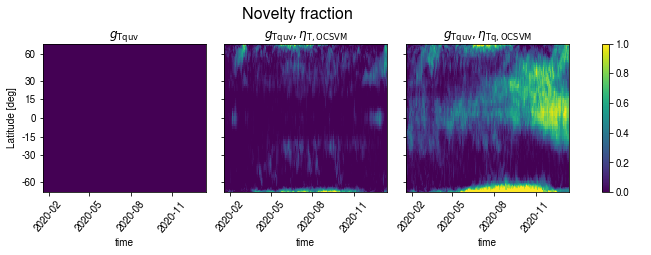

In [67]:
runs=["$g_\mathrm{Tquv}$",  "$g_\mathrm{Tquv}, \eta_{\mathrm{T, OCSVM}}$", "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]
#runs=['Baseline',  "$g_\mathrm{Tquv}, \eta_{\mathrm{T, OCSVM}}$", "$g_\mathrm{Tquv}, \eta_{\mathrm{Tq, OCSVM}}$"]

da_ = ds_diags_transformed_lat.sel(run=runs)['is_novelty_zonal_mean_value']
f = da_.plot(col="run", x="time", rasterized=True)

for i, exp in enumerate(da_.run.values):
    ax = f.axes[0][i]
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=50)
    ax.set_title(exp)

    ax = f.axes[0][0].set_ylabel("Latitude [deg]")    

    

plt.yticks(tick_loc_sin, tick_loc)  # Set label locations.

f.cbar.ax.set_ylabel(" ")
plt.suptitle("Novelty fraction", x=0.425, y=1.05, fontsize=16)
save_fig("zonal_mean_is_novelty")